<a href="https://colab.research.google.com/github/aakarsh-s/aakarsh-s/blob/main/PneumoniaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.regularizers import l2
import tensorflow.keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)

def flip_left_right(data, prob):
  fun = augmenters.Fliplr(p = prob)
  return augment(data, fun)

def flip_up_down(data, prob):
  fun = augmenters.Flipud(p = prob)
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    field_data, field_labels = get_data_split('field', flatten, all_data, metadata, image_shape)
    field_data[:,:,:,2] = field_data[:,:,:,0]
    field_data[:,:,:,1] = field_data[:,:,:,0]

    #make data messier
    rand = random.uniform(-1, 1)

    for i in range(len(field_data)):
      image = field_data[i]

      if abs(rand) < 0.5:
        image = rotate(image, rotate = rand * 40)
      elif abs(rand) < 0.8:
        image = shear(image, shear = rand*40)
      field_data[i] = image
    return field_data, field_labels

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 4)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    model.add(Dropout(0.5))

    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=1e-5, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = False):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    # expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))
    # expert_model.add(Dropout(0.3))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

metadata.csv        100%[===================>]  39.56K  --.-KB/s    in 0s      
image_data.npy      100%[===================>] 131.25M   119MB/s    in 1.1s    


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.5120 - loss: 2.0423 - val_accuracy: 0.6500 - val_loss: 2.0162
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5646 - loss: 2.0119 - val_accuracy: 0.7400 - val_loss: 1.9925
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6260 - loss: 1.9799 - val_accuracy: 0.7175 - val_loss: 1.9640
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6805 - loss: 1.9472 - val_accuracy: 0.7325 - val_loss: 1.9399
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6953 - loss: 1.9222 - val_accuracy: 0.7425 - val_loss: 1.9138
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7221 - loss: 1.8958 - val_accuracy: 0.8225 - val_loss: 1.8799
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7361 - loss: 1.8695 - val_accuracy: 0.7975 - val_loss: 1.8568
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7681 - loss: 1.8307 - val_accuracy: 0.7300 - val_lo

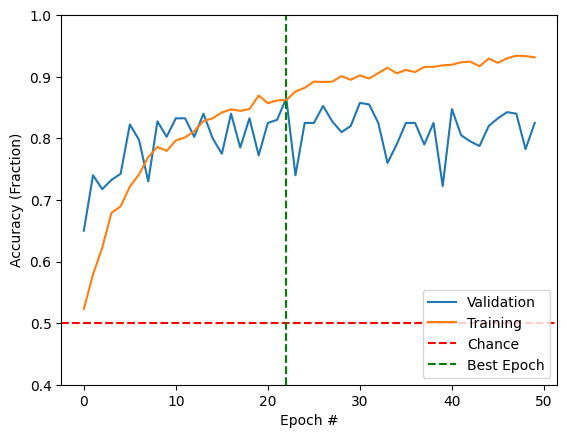

In [ ]:
X_train, y_train = get_train_data()
X_test, y_test   = get_test_data()

cnn = CNNClassifier(num_hidden_layers = 2)
cnn_history = cnn.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
plot_acc(cnn_history)


In [ ]:
X_field, y_field = get_field_data()

In [ ]:
y_pred = (cnn.predict(X_field) > 0.5)
accuracy_score(y_field, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


0.5125

In [ ]:
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()
X_field, y_field = get_field_data()

average_accuracy = 0.0
for i in range(5):
  cnn_temp = CNNClassifier(5)
  cnn_temp.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), shuffle = True, callbacks = (monitor))

  y_pred = (cnn_temp.predict(X_field) > 0.5)
  accuracy = accuracy_score(y_field, y_pred)
  print('Accuracy on this run: %0.2f' % accuracy)

  average_accuracy +=accuracy / 5.0
print('Average accuracy: ', average_accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.4986 - loss: 3.9202 - val_accuracy: 0.6150 - val_loss: 3.8732
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5290 - loss: 3.8595 - val_accuracy: 0.6125 - val_loss: 3.8156
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5171 - loss: 3.8011 - val_accuracy: 0.6175 - val_loss: 3.7584
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5128 - loss: 3.7461 - val_accuracy: 0.5100 - val_loss: 3.7021
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5141 - loss: 3.6890 - val_accuracy: 0.5100 - val_loss: 3.6467
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5054 - loss: 3.6356 - val_accuracy: 0.5100 - val_loss: 3.5920
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5187 - loss: 3.5806 - val_accuracy: 0.5050 - val_loss: 3.5379
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5496 - loss: 3.5245 - val_accuracy: 0.5050 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.4859 - loss: 3.9406 - val_accuracy: 0.5950 - val_loss: 3.8926
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5170 - loss: 3.8775 - val_accuracy: 0.5525 - val_loss: 3.8356
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5353 - loss: 3.8218 - val_accuracy: 0.5000 - val_loss: 3.7790
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5060 - loss: 3.7666 - val_accuracy: 0.5000 - val_loss: 3.7236
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5577 - loss: 3.7073 - val_accuracy: 0.5075 - val_loss: 3.6691
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5499 - loss: 3.6550 - val_accuracy: 0.5025 - val_loss: 3.6149
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5407 - loss: 3.6016 - val_accuracy: 0.5100 - val_loss: 3.5613
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5526 - loss: 3.5474 - val_accuracy: 0.5100 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.4939 - loss: 3.9249 - val_accuracy: 0.5000 - val_loss: 3.8792
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5100 - loss: 3.8627 - val_accuracy: 0.5000 - val_loss: 3.8216
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5059 - loss: 3.8074 - val_accuracy: 0.5000 - val_loss: 3.7648
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5281 - loss: 3.7484 - val_accuracy: 0.5000 - val_loss: 3.7086
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5076 - loss: 3.6957 - val_accuracy: 0.5000 - val_loss: 3.6530
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5138 - loss: 3.6388 - val_accuracy: 0.5000 - val_loss: 3.5982
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5304 - loss: 3.5842 - val_accuracy: 0.5000 - val_loss: 3.5438
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5283 - loss: 3.5302 - val_accuracy: 0.5000 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.4890 - loss: 3.9257 - val_accuracy: 0.5200 - val_loss: 3.8772
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5060 - loss: 3.8633 - val_accuracy: 0.5025 - val_loss: 3.8196
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5264 - loss: 3.8046 - val_accuracy: 0.5025 - val_loss: 3.7629
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5003 - loss: 3.7497 - val_accuracy: 0.5025 - val_loss: 3.7073
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5092 - loss: 3.6939 - val_accuracy: 0.5000 - val_loss: 3.6520
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5317 - loss: 3.6375 - val_accuracy: 0.5000 - val_loss: 3.5975
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5388 - loss: 3.5825 - val_accuracy: 0.5000 - val_loss: 3.5439
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5303 - loss: 3.5308 - val_accuracy: 0.5000 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.4954 - loss: 3.9353 - val_accuracy: 0.5000 - val_loss: 3.8886
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4863 - loss: 3.8746 - val_accuracy: 0.5000 - val_loss: 3.8294
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5024 - loss: 3.8146 - val_accuracy: 0.5000 - val_loss: 3.7710
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5192 - loss: 3.7562 - val_accuracy: 0.5000 - val_loss: 3.7134
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5108 - loss: 3.6993 - val_accuracy: 0.5000 - val_loss: 3.6567
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5066 - loss: 3.6439 - val_accuracy: 0.5000 - val_loss: 3.6006
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5302 - loss: 3.5855 - val_accuracy: 0.5000 - val_loss: 3.5455
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5179 - loss: 3.5316 - val_accuracy: 0.5000 - val_loss

TEST DATA
Label: 1.0


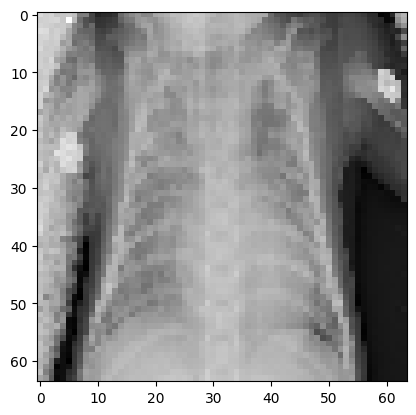

Label: 1.0


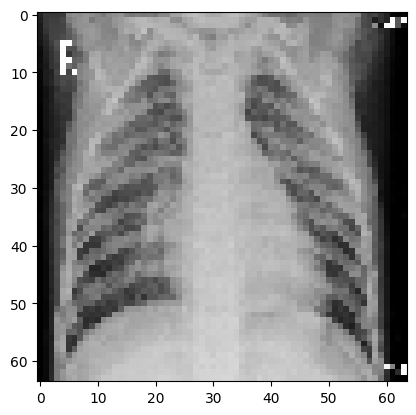

FIELD DATA
Label: 1.0


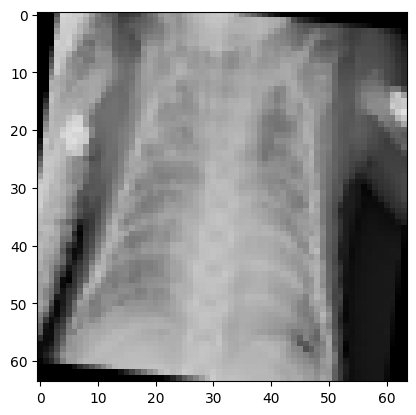

Label: 1.0


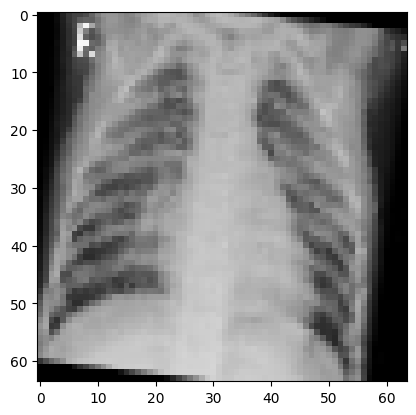

TRAIN DATA
Label: 0.0


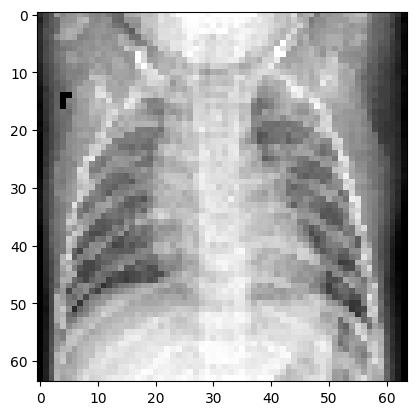

Label: 0.0


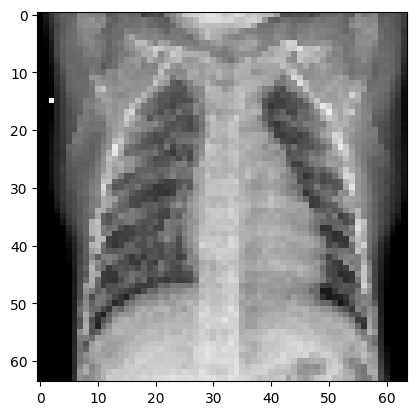

In [ ]:
print("TEST DATA")
for i in range(2):
  plot_one_image(X_test, y_test, i)

print("FIELD DATA")
for i in range(2):
  plot_one_image(X_field, y_field, i)

print("TRAIN DATA")
for i in range(2):
  plot_one_image(X_train, y_train, i)

Label: 


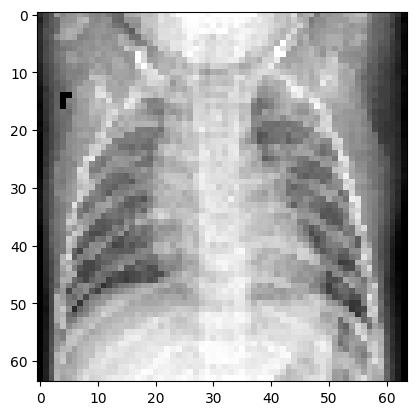

Label: 


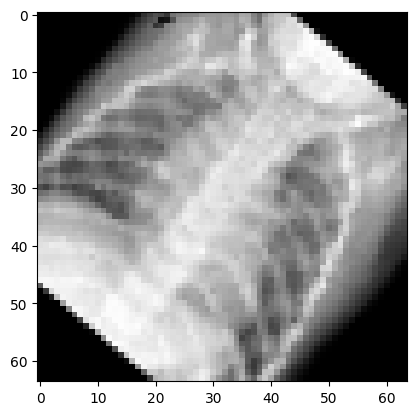

In [ ]:
image = X_train[0]
plot_one_image(image)
new_image = rotate(image, rotate = 40)
plot_one_image(new_image)

Label: 


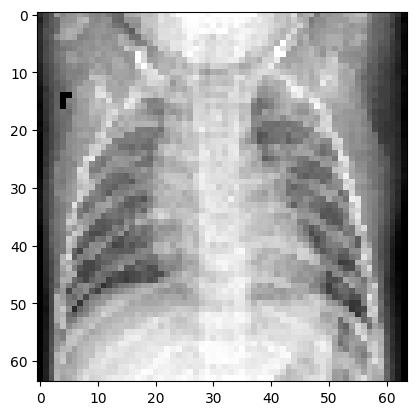

Label: 


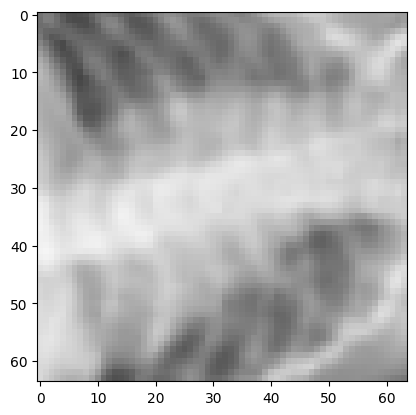

In [ ]:
#YOUR CODE HERE
image = X_train[0]
plot_one_image(image)
new_image = rotate(new_image, rotate = 40)
new_image = scale(new_image, scale = 1.5)

plot_one_image(new_image)


In [ ]:
train_data_rotated_10 = rotate(X_train, rotate=10)

In [ ]:
# Data augmentation
# Data augmentation
# Import necessary library
from imgaug import augmenters as iaa

# Data augmentation using provided functions
train_data_rotated_45 = rotate(X_train, rotate=45)
train_data_sheared_15 = shear(X_train, shear=15)
train_data_scaled_0_8 = scale(X_train, scale=0.8)
train_data_flipped_lr = flip_left_right(X_train, prob=0.5)
train_data_flipped_ud = flip_up_down(X_train, prob=0.5)
train_data_no_green = remove_color(X_train, channel=1)

# Example of additional augmentation functions using imgaug
def add_gaussian_noise(data, mean=0, stddev=0.1):
    aug = iaa.AdditiveGaussianNoise(mean, stddev)
    return augment(data, aug)

def adjust_contrast(data, factor):
    aug = iaa.LinearContrast(factor)
    return augment(data, aug)

def adjust_brightness(data, factor):
    aug = iaa.Multiply((factor, factor))
    return augment(data, aug)

def random_crop(data, crop_size):
    aug = iaa.CropToFixedSize(width=crop_size[0], height=crop_size[1])
    return augment(data, aug)

def adjust_gamma(data, gamma):
    aug = iaa.GammaContrast(gamma)
    return augment(data, aug)

# Using new augmentations
train_data_gaussian_noise = add_gaussian_noise(X_train, mean=0, stddev=0.05)
train_data_contrast = adjust_contrast(X_train, factor=1.5)
train_data_brightness = adjust_brightness(X_train, factor=1.2)
train_data_cropped = random_crop(X_train, crop_size=(100, 100))
train_data_gamma = adjust_gamma(X_train, gamma=1.5)

In [ ]:
all_data, all_labels = combine_data(
    [X_train, train_data_rotated_45, train_data_sheared_15, train_data_scaled_0_8,
     train_data_flipped_lr, train_data_flipped_ud, train_data_no_green,
     train_data_gaussian_noise, train_data_contrast, train_data_brightness,
     train_data_cropped, train_data_gamma],
    [y_train] * 12
    )

In [ ]:
  X_train, y_train = get_train_data()
  X_test, y_test   = get_test_data()
  X_field, y_field   = get_field_data()

  ### YOUR CODE HERE
  average_accuracy = 0.0

  for i in range(5):
    cnn = CNNClassifier(2)
    cnn.fit(all_data, all_labels, epochs = 100, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
    predictions = (cnn.predict(X_field) > 0.5)
    accuracy = accuracy_score(y_field, predictions)
    print('Accuracy:%0.2f'%accuracy)
    average_accuracy += accuracy

  average_accuracy /= 5.0

  print('Average accuracy: ', average_accuracy)

### END CODE

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5881 - loss: 1.9545 - val_accuracy: 0.8475 - val_loss: 1.7221
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7736 - loss: 1.6769 - val_accuracy: 0.8500 - val_loss: 1.4754
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8357 - loss: 1.4511 - val_accuracy: 0.8175 - val_loss: 1.3576
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8709 - loss: 1.2762 - val_accuracy: 0.8375 - val_loss: 1.2312
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8898 - loss: 1.1452 - val_accuracy: 0.8500 - val_loss: 1.1205
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9038 - loss: 1.0320 - val_accuracy: 0.8025 - val_loss: 1.1275
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9081 - loss: 0.9466 - val_accuracy: 0.7750 - val_loss: 1.1309
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9192 - loss: 0.8672 - val_acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5963 - loss: 1.9641 - val_accuracy: 0.8400 - val_loss: 1.7209
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7765 - loss: 1.6883 - val_accuracy: 0.8400 - val_loss: 1.5072
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8368 - loss: 1.4563 - val_accuracy: 0.8400 - val_loss: 1.3419
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8712 - loss: 1.2852 - val_accuracy: 0.8500 - val_loss: 1.2002
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8813 - loss: 1.1534 - val_accuracy: 0.8425 - val_loss: 1.1155
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8977 - loss: 1.0366 - val_accuracy: 0.7775 - val_loss: 1.1441
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9120 - loss: 0.9394 - val_accuracy: 0.7550 - val_loss: 1.1741
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9173 - loss: 0.8582 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6120 - loss: 1.9598 - val_accuracy: 0.8475 - val_loss: 1.7248
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7847 - loss: 1.6717 - val_accuracy: 0.8475 - val_loss: 1.4896
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8391 - loss: 1.4446 - val_accuracy: 0.8500 - val_loss: 1.3315
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8720 - loss: 1.2732 - val_accuracy: 0.7900 - val_loss: 1.2833
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8913 - loss: 1.1325 - val_accuracy: 0.8225 - val_loss: 1.1610
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9036 - loss: 1.0215 - val_accuracy: 0.8175 - val_loss: 1.0958
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9118 - loss: 0.9322 - val_accuracy: 0.7475 - val_loss: 1.1781
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9160 - loss: 0.8545 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5978 - loss: 1.9577 - val_accuracy: 0.8125 - val_loss: 1.7469
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7644 - loss: 1.6961 - val_accuracy: 0.8300 - val_loss: 1.5107
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8214 - loss: 1.4717 - val_accuracy: 0.8400 - val_loss: 1.3357
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8649 - loss: 1.2874 - val_accuracy: 0.8275 - val_loss: 1.2285
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8890 - loss: 1.1401 - val_accuracy: 0.8375 - val_loss: 1.1148
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9013 - loss: 1.0239 - val_accuracy: 0.7725 - val_loss: 1.1573
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9101 - loss: 0.9329 - val_accuracy: 0.7675 - val_loss: 1.1352
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9234 - loss: 0.8380 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6039 - loss: 1.9515 - val_accuracy: 0.8450 - val_loss: 1.7237
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7800 - loss: 1.6838 - val_accuracy: 0.8225 - val_loss: 1.5122
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8393 - loss: 1.4563 - val_accuracy: 0.8500 - val_loss: 1.3192
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8663 - loss: 1.2893 - val_accuracy: 0.8400 - val_loss: 1.2307
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8928 - loss: 1.1536 - val_accuracy: 0.8225 - val_loss: 1.1706
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9021 - loss: 1.0473 - val_accuracy: 0.8000 - val_loss: 1.1579
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9131 - loss: 0.9558 - val_accuracy: 0.8050 - val_loss: 1.0850
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9203 - loss: 0.8780 - val_accu

In [ ]:
from tensorflow.keras.optimizers import Adam

# Set a lower learning rate
learning_rate = 0.00001  # Adjust this value as needed

cnn = CNNClassifier(num_hidden_layers=4)
cnn.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = cnn.fit(all_data, all_labels, epochs=15, validation_data=(X_test, y_test), shuffle=True)
predictions = (cnn.predict(X_field) > 0.5)
accuracy = accuracy_score(y_field, predictions)
print('Accuracy: %0.2f' % accuracy)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5303 - loss: 3.1727 - val_accuracy: 0.7100 - val_loss: 2.8212
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6696 - loss: 2.7135 - val_accuracy: 0.8075 - val_loss: 2.3973
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7765 - loss: 2.2992 - val_accuracy: 0.7875 - val_loss: 2.0730
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8202 - loss: 1.9932 - val_accuracy: 0.8100 - val_loss: 1.8556
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8460 - loss: 1.7743 - val_accuracy: 0.8125 - val_loss: 1.7190
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8589 - loss: 1.6164 - val_accuracy: 0.8325 - val_loss: 1.5513
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8711 - loss: 1.4919 - val_accuracy: 0.8450 - val_loss: 1.4252
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8839 - loss: 1.3830 - val_accuracy: 0

In [ ]:
from google.colab import drive
import tensorflow as tf
drive.mount('/content/gdrive')
save_path = "/content/gdrive/My Drive/cnn_model.keras"

import tensorflow as tf
cnn.save(save_path)

Mounted at /content/gdrive
